In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
import pymc as pm
from properscoring import crps_ensemble
import random
from patsy import dmatrix
import arviz as az
import matplotlib.pyplot as plt



sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds

M = 40
D = 40

start_year = 2022
end_year = 2022
seed = 123

# 123, 2019, 2023, 15

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [2]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M, norm=False)
true_count_dataset = TrueCountDataset(delays_df)


In [3]:
# End of 2023 appears to have some incomplete data
if end_year == 2023:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-25", freq='D'))
else:
    dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))

In [4]:
dates

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2022-01-03 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2022-01-05 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-07 00:00:00'),
 Timestamp('2022-01-08 00:00:00'),
 Timestamp('2022-01-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-01-11 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2022-01-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-17 00:00:00'),
 Timestamp('2022-01-18 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2022-01-20 00:00:00'),
 Timestamp('2022-01-21 00:00:00'),
 Timestamp('2022-01-22 00:00:00'),
 Timestamp('2022-01-23 00:00:00'),
 Timestamp('2022-01-24 00:00:00'),
 Timestamp('2022-01-25 00:00:00'),
 Timestamp('2022-01-26 00:00:00'),
 Timestamp('2022-01-27 00:00:00'),
 Timestamp('2022-01-28 00:00:00'),
 Timestamp('2022-01-

In [5]:
class PropBNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        window_dates = [date - pd.Timedelta(days=i) for i in range(M)]
        window_dates = sorted(window_dates)
        Z_obs = self.partial_count_obj.get_obs(date)
        y_true = [self.true_count_obj.get_y(day) for day in window_dates]
        y_true = np.array(y_true).reshape(M)
        dow = date.day_of_week
        return Z_obs, y_true, window_dates

set_seed(seed)
dataset = PropBNNDataset(partial_count_dataset, true_count_dataset, dates)




In [6]:
def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        cores=1,
        init="adapt_diag",
        chains=1,
        draws=500,
        tune=500,
        target_accept=0.9,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def get_mask(D):
        mask_matrix = np.ones(shape=(D, D), dtype=bool)
        for i in range(D):
            for j in range(D):
                if i + j > D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix

def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)


In [7]:
len(dataset)

365

In [8]:
# Constants
t = np.arange(0, M)
t_week = t % 14
t_norm = t / M

n = 14
fourier_basis_biweek = create_fourier_features(t, n=n, p=3.5)
fourier_basis_week = create_fourier_features(t, n=n, p=7)

fourier_basis_biweek = fourier_basis_biweek - fourier_basis_biweek.mean(0, keepdims=True)
fourier_basis_week = fourier_basis_week - fourier_basis_week.mean(0, keepdims=True)


spline_week = dmatrix(
    "cc(t_week, df=7)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)

spline_trend = dmatrix(
    "cc(t_norm, df=20)", {"t_norm": t_norm}, return_type='dataframe'
)
X_trend = np.asarray(spline_trend)






t_input = np.arange(M)[:, None] / M
time_input = np.concatenate([t_input, fourier_basis_biweek, fourier_basis_week], axis=1)

from sklearn.preprocessing import StandardScaler


scaler_week = StandardScaler()
X_week = scaler_week.fit_transform(X_week)

scaler_trend = StandardScaler()
X_trend = scaler_week.fit_transform(X_trend)







mask = np.ones((M,D), dtype=bool)
mask[-D:,:] = get_mask(D)

Z_obs, y_true, window_dates = dataset.__getitem__(89)
Z_norm = (Z_obs - Z_obs.mean()) / (Z_obs.std() + 1e-6)



In [9]:
with pm.Model() as PropBNN:
    const = pm.Normal("const", mu=pm.math.log(Z_obs.mean()+1), sigma=0.3)
    beta_linear = pm.Normal("beta_linear", mu=0, sigma=0.3)

    # Trend spline coefficients
    sigma_trend = pm.HalfNormal("sigma_trend", 0.01)
    raw_trend = pm.Normal("raw_trend", mu=0, sigma=1, shape=X_trend.shape[1])
    beta_trend = pm.Deterministic("beta_rend", raw_trend*sigma_trend)
    trend_spline = pm.math.dot(X_trend, beta_trend)




    # Create lam param 
    log_lam = pm.Deterministic(
            "log_lam",  const + trend_spline + beta_linear*t_norm
        )

    # NN for proportions from time inputs
    n_hidden = 16
    sigma_net = 0.15
    
    W1 = pm.Normal("W1", 0, sigma_net, shape=(1+4*n, n_hidden))
    b1 = pm.Normal("b1", 0, sigma_net, shape=(n_hidden,))
    h1 = silu(pm.math.dot(time_input, W1) + b1)

    W2 = pm.Normal("W2", 0, sigma_net, shape=(n_hidden, D))
    b2 = pm.Normal("b2", 0, sigma_net, shape=(D,))
    p_raw = pm.math.dot(h1, W2) + b2
    log_p = pm.math.log_softmax(p_raw, axis=1)


    # Make mu param per tim/delay point
    log_mu = log_lam[:, None] + log_p
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Overdispersion
    theta = pm.Exponential("theta", lam=1/(Z_obs.mean()+1))

    # Observed data
    z = pm.NegativeBinomial("z", mu[mask], theta, observed=Z_obs[mask])

    D = np.diff(np.eye(X_trend.shape[1]), 2, axis=0)  # second-difference matrix
    penalty = pm.Potential("spline_smoothness", -0.9 * pm.math.sum((D @ beta_trend)**2))


    # Generated Quantities
    p = pm.Deterministic("p", pm.math.exp(log_p))
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))


    idata = pm.sample(progressbar=True, **sampler_kwargs())

    # Weight

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1000,0,0.06,63


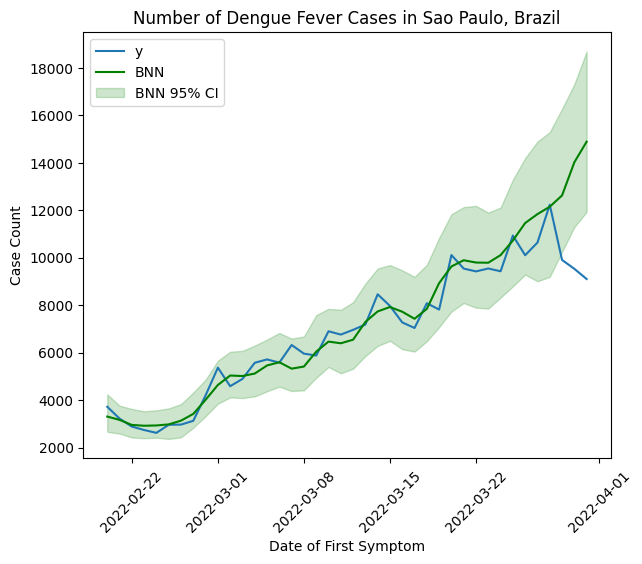

In [10]:
# idx = 30
# path = f"/Volumes/GLENN_SSD/V3/PropBNN_idata_{idx}.nc"
# Z_obs, y_true, window_dates = dataset.__getitem__(idx)
# idata = az.from_netcdf(path)

mu_samples = az.extract(idata, group='posterior', num_samples=1000)['mu']
theta_samples = az.extract(idata, group='posterior', num_samples=1000)['theta']

r = np.broadcast_to(theta_samples, mu_samples.shape)
mu = mu_samples
p = r / (r + mu)

z_samples = np.random.negative_binomial(r, p, size=mu_samples.shape)
z_samples.shape
y_preds = z_samples.sum(1)
y_preds.shape

y_preds_med = np.quantile(y_preds, 0.5, axis=1)
y_preds_lower = np.quantile(y_preds, 0.025, axis=1)
y_preds_upper = np.quantile(y_preds, 0.975, axis=1)

plt.plot(window_dates, y_true, label='y')

plt.plot(window_dates, y_preds_med, label='BNN', color='green')
plt.fill_between(window_dates, y_preds_lower, y_preds_upper, color='green', alpha=0.2, label='BNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

In [11]:
p_post_samples = az.extract(idata, group='posterior', num_samples=1000)['p']
p_post_samples.mean("sample")[:, 0]

<xarray.DataArray 'p' (p_dim_0: 40)> Size: 320B
array([0.0610836 , 0.09373122, 0.09305329, 0.09674149, 0.09249618,
       0.08997541, 0.06591496, 0.061082  , 0.09414829, 0.09352389,
       0.09717688, 0.09283353, 0.09042213, 0.06602475, 0.06106007,
       0.09453685, 0.09395272, 0.09756712, 0.0931504 , 0.09084009,
       0.06610917, 0.06101824, 0.09489665, 0.09433973, 0.09791264,
       0.09344681, 0.0912294 , 0.0661688 , 0.06095698, 0.09522751,
       0.09468498, 0.09821405, 0.09372282, 0.09159028, 0.06620429,
       0.06087679, 0.09552927, 0.09498868, 0.09847209, 0.09397852])
Coordinates:
  * p_dim_0  (p_dim_0) int64 320B 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
    p_dim_1  int64 8B 0

In [12]:
mu_post_samples = az.extract(idata, group='posterior', num_samples=1000)['mu']
mu_post_samples.mean("sample")[:, 0]

<xarray.DataArray 'mu' (mu_dim_0: 40)> Size: 320B
array([ 203.17253052,  298.5412962 ,  276.81516058,  284.39127507,
        275.18516466,  268.78718291,  205.00462163,  212.40391335,
        381.75859718,  438.81205208,  491.12049733,  465.452017  ,
        460.90028789,  362.03200954,  343.19136858,  508.41356105,
        515.50318518,  595.60850112,  605.08854944,  585.91457811,
        439.98887322,  443.6014203 ,  742.24993764,  752.06323929,
        755.64954875,  698.69094574,  720.93569108,  586.7017384 ,
        586.1278456 ,  939.68316967,  926.96921718,  961.0764436 ,
        954.87709462,  995.87713278,  757.95629366,  720.64809559,
       1159.44718832, 1212.24871604, 1382.72316798, 1404.72330225])
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 320B 0 1 2 3 4 5 6 7 ... 32 33 34 35 36 37 38 39
    mu_dim_1  int64 8B 0

In [13]:
mu_post_samples = az.extract(idata, group='posterior', num_samples=1000)['const']
np.exp(mu_post_samples.mean('sample'))

<xarray.DataArray 'const' ()> Size: 8B
array(3051.55816661)

In [14]:
# R-hat should be < 1.01 for all parameters
print(az.rhat(idata).max())

# Effective sample size should be > 100 per chain
print(az.ess(idata).min())

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


<xarray.Dataset> Size: 128B
Dimensions:            ()
Data variables: (12/16)
    const              float64 8B nan
    beta_linear        float64 8B nan
    sigma_trend_log__  float64 8B nan
    raw_trend          float64 8B nan
    W1                 float64 8B nan
    b1                 float64 8B nan
    ...                 ...
    theta              float64 8B nan
    beta_rend          float64 8B nan
    log_lam            float64 8B nan
    mu                 float64 8B nan
    p                  float64 8B nan
    lam                float64 8B nan
<xarray.Dataset> Size: 128B
Dimensions:            ()
Data variables: (12/16)
    const              float64 8B 72.01
    beta_linear        float64 8B 71.48
    sigma_trend_log__  float64 8B 135.8
    raw_trend          float64 8B 262.9
    W1                 float64 8B 3.163
    b1                 float64 8B 2.362
    ...                 ...
    theta              float64 8B 388.4
    beta_rend          float64 8B 143.6
    log_lam 

In [15]:
import arviz as az
import numpy as np

# ===== METHOD 1: CHECK SPECIFIC NETWORK PARAMETERS =====
print("=== Network Parameter R-hat ===")
rhat_all = az.rhat(idata)
network_params = ['W1', 'W2', 'Wz', 'b1', 'b2', 'bz', 'net_scale']

for param in network_params:
    if param in rhat_all:
        rhat_val = rhat_all[param].values
        if hasattr(rhat_val, 'max'):  # Array of values
            print(f"{param}: max={rhat_val.max():.4f}, min={rhat_val.min():.4f}")
        else:  # Single value
            print(f"{param}: {rhat_val:.4f}")

print("\n=== Network Parameter ESS ===")
ess_all = az.ess(idata)
for param in network_params:
    if param in ess_all:
        ess_val = ess_all[param].values
        if hasattr(ess_val, 'min'):  # Array of values
            print(f"{param}: min={ess_val.min():.0f}, max={ess_val.max():.0f}")
        else:  # Single value
            print(f"{param}: {ess_val:.0f}")

# ===== METHOD 2: FIND WORST PERFORMERS =====
print("\n=== Worst R-hat Values ===")
rhat_flat = {}
for var_name in rhat_all.data_vars:
    values = rhat_all[var_name].values
    if hasattr(values, 'flatten'):  # Multi-dimensional
        rhat_flat[var_name] = values.max()
    else:  # Scalar
        rhat_flat[var_name] = float(values)

# Sort by worst R-hat
worst_rhat = sorted(rhat_flat.items(), key=lambda x: x[1], reverse=True)
for param, rhat_val in worst_rhat[:10]:  # Top 10 worst
    print(f"{param}: {rhat_val:.4f}")

print("\n=== Lowest ESS Values ===")
ess_flat = {}
for var_name in ess_all.data_vars:
    values = ess_all[var_name].values
    if hasattr(values, 'flatten'):  # Multi-dimensional
        ess_flat[var_name] = values.min()
    else:  # Scalar
        ess_flat[var_name] = float(values)

# Sort by lowest ESS
worst_ess = sorted(ess_flat.items(), key=lambda x: x[1])
for param, ess_val in worst_ess[:10]:  # Bottom 10
    print(f"{param}: {ess_val:.0f}")

# ===== METHOD 3: SUMMARY STATISTICS =====
print("\n=== Overall Network Diagnostics ===")
network_rhat_vals = []
network_ess_vals = []

for param in network_params:
    if param in rhat_all:
        vals = rhat_all[param].values
        if hasattr(vals, 'flatten'):
            network_rhat_vals.extend(vals.flatten())
        else:
            network_rhat_vals.append(vals)
    
    if param in ess_all:
        vals = ess_all[param].values  
        if hasattr(vals, 'flatten'):
            network_ess_vals.extend(vals.flatten())
        else:
            network_ess_vals.append(vals)

if network_rhat_vals:
    print(f"Network R-hat: max={np.max(network_rhat_vals):.4f}, mean={np.mean(network_rhat_vals):.4f}")
if network_ess_vals:
    print(f"Network ESS: min={np.min(network_ess_vals):.0f}, mean={np.mean(network_ess_vals):.0f}")

# ===== METHOD 4: CHECK PROBLEM THRESHOLD =====
print("\n=== Problem Detection ===")
bad_rhat = [name for name, val in rhat_flat.items() if val > 1.01]
low_ess = [name for name, val in ess_flat.items() if val < 400]

print(f"Parameters with R-hat > 1.01: {bad_rhat}")
print(f"Parameters with ESS < 400: {low_ess}")

# ===== METHOD 5: VISUAL DIAGNOSTICS =====
print("\n=== Visual Diagnostics (run these separately) ===")
print("# Trace plots for worst mixing parameters:")
if bad_rhat:
    print(f"az.plot_trace(idata, var_names=['{bad_rhat[0]}'])")
    
print("# R-hat plot for all parameters:")
print("az.plot_rhat(idata)")

print("# ESS plot for all parameters:")  
print("az.plot_ess(idata)")

=== Network Parameter R-hat ===
W1: max=nan, min=nan
W2: max=nan, min=nan
b1: max=nan, min=nan
b2: max=nan, min=nan

=== Network Parameter ESS ===
W1: min=3, max=1349
W2: min=3, max=732
b1: min=2, max=60
b2: min=144, max=864

=== Worst R-hat Values ===
const: nan
beta_linear: nan
sigma_trend_log__: nan
raw_trend: nan
W1: nan
b1: nan
W2: nan
b2: nan
theta_log__: nan
sigma_trend: nan

=== Lowest ESS Values ===
b1: 2
W2: 3
W1: 3
beta_linear: 71
const: 72
mu: 113
p: 118
sigma_trend_log__: 136
sigma_trend: 136
log_lam: 139

=== Overall Network Diagnostics ===
Network R-hat: max=nan, mean=nan
Network ESS: min=2, mean=178

=== Problem Detection ===
Parameters with R-hat > 1.01: []
Parameters with ESS < 400: ['const', 'beta_linear', 'sigma_trend_log__', 'raw_trend', 'W1', 'b1', 'W2', 'b2', 'theta_log__', 'sigma_trend', 'theta', 'beta_rend', 'log_lam', 'mu', 'p', 'lam']

=== Visual Diagnostics (run these separately) ===
# Trace plots for worst mixing parameters:
# R-hat plot for all parameters:

In [16]:
# T = 76
# N = 500
# chains = 1


# mu_samples = np.ones((T, D, chains*N))
# theta_samples = np.ones((T, D, chains*N))
# z_samples = np.zeros((T, D, chains*N))

# # for idx in range(T):
# for idx in range(T):
#     path = f"/Volumes/GLENN_SSD/V3/PropBNN_idata_{idx}.nc"
#     idata = az.from_netcdf(path)
#     mu = az.extract(idata, group='posterior')['mu'][-1, :, :]
#     theta = az.extract(idata, group='posterior')['theta']
    
#     if len(theta.shape) == 1:
#         theta = np.expand_dims(theta, axis=0)
#     else:
#         theta = theta[-1, :, :]

#     theta = np.broadcast_to(theta, mu.shape)

#     p = theta / (theta + mu)
#     z = np.random.negative_binomial(theta, p, size=mu.shape)
    
#     mu_samples[idx, :, :] = mu
#     theta_samples[idx, :, :] = theta
#     z_samples[idx, :, :] = z


# y_pred = z_samples.sum(1)
# y_pred.shape


# y_true = [dataset.__getitem__(idx)[1][-1] for idx in range(T)]
# window_dates = [dataset.__getitem__(idx)[2][-1] for idx in range(T)]

# y_pred_med = np.quantile(y_pred, 0.5, axis=1)
# y_pred_lower = np.quantile(y_pred, 0.025, axis=1)
# y_pred_upper = np.quantile(y_pred, 0.975, axis=1)

# plt.plot(window_dates, y_true, label='y')

# plt.plot(window_dates, y_pred_med, label='BNN', color='green')
# plt.fill_between(window_dates, y_pred_lower, y_pred_upper, color='green', alpha=0.2, label='BNN 95% CI')


# plt.legend()
# plt.tight_layout()
# plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
# plt.xlabel("Date of First Symptom")
# plt.ylabel("Case Count")
# plt.xticks(rotation=45)
# plt.show()

